# Cognitive Services "coffee choice" Personalizer demo 
https://github.com/Azure-Samples/cognitive-services-personalizer-samples

In this example, we will use Azure Personalizer Service to predict what Coffee a person (Alice, Bob, Cathy and Dave) prefers using the weather condition and time of day. File "example.json" contains their preferred choices of coffee (set deterministically for the simplicity of this example). We will compare this data with the predictions from the service and generate rewards (0 or 1) based on the match and send it back to the service for training the model, to learn each person's preferences.

Note that a model is exported every 5 minutes (current default) if you are using the Cognitive Services instance of the Personalizer service, so you need to wait at least until that time has expired then to actually observe some learning in the rewards returned. Exploration is set at 20%. You can experiment with the model training defaults in the Settings blade for the Personalizer resource in the [Azure Portal](https://ms.portal.azure.com).

This implementation calls the [Personalizer service RESTful API](https://westus2.dev.cognitive.microsoft.com/docs/services/personalizer-api/operations/Rank); a set of http requests that the Personalizer exposes. The model iterates over events, performing _on-line learning._ The sequence of operation is

- Observe the features (simulated in this demo) of the current event: The weather and time of day for this person's coffee choice.
- Place a _rank request_ to the Personalizer Service, using the model to predict the person's preferred choice from the set of specified _actions_.
- Compare the person's true choice with the predicted, and compute a model _reward_: 1 if they agree, 0 otherwise.
- Send the _reward_ back to the Service, to train the model on persons' preferences.

We record the sequence of rewards.  After running numerous events we should see the prediction accuracy of the model improve. 


In [6]:
import json
# This will fail on the first import.  Just run it again and the error will disappear
import matplotlib.pyplot as plt
import random 
import requests
import time
import uuid
from pandas import DataFrame
from scipy import stats

In [8]:
# Replace 'personalization_base_url' and 'subscription_key' with your valid endpoint values.
endpoint = "https://westus2.api.cognitive.microsoft.com/"
personalization_base_url = endpoint # "http://localhost:5000"
subscription_key = "3a1ab38574454951a75eb7c9abfdd924" 

In [9]:
# Assemble the parts of the RESTFUL api calls. 
personalization_rank_url = personalization_base_url + "/personalizer/v1.0/rank"
personalization_reward_url = personalization_base_url + "/personalizer/v1.0/events/" #add "{eventId}/reward"
headers = {'Ocp-Apim-Subscription-Key' : subscription_key, 'Content-Type': 'application/json'}

examplepath = "example.json"
requestpath = "rankrequest.json"
actionfeaturespath = "actionfeatures.json"

random.seed(time.time())

userpref = None 
rankactionsjsonobj = None 
actionfeaturesobj = None

with open(examplepath) as handle:
    userpref = json.loads(handle.read())

with open(requestpath) as handle:
    rankactionsjsonobj = json.loads(handle.read())  
    
with open(actionfeaturespath) as handle:
    actionfeaturesobj = json.loads(handle.read())

In [10]:
rankactionsjsonobj

{'contextFeatures': [],
 'actions': [],
 'excludedActions': [],
 'eventId': '',
 'deferActivation': False}

In [11]:
# Person's coffee preferences as a function of weather and time of day. 
DataFrame(userpref)

,Alice,Bob,Cathy,Dave
Rainy,"{'Morning': 'Latte', 'Afternoon': 'Cappucino',...","{'Morning': 'Latte', 'Afternoon': 'Latte', 'Ev...","{'Morning': 'Cappucino', 'Afternoon': 'Latte',...","{'Morning': 'Latte', 'Afternoon': 'Latte', 'Ev..."
Snowy,"{'Morning': 'Cappucino', 'Afternoon': 'Cappuci...","{'Morning': 'Iced mocha', 'Afternoon': 'Iced m...","{'Morning': 'Cold brew', 'Afternoon': 'Iced mo...","{'Morning': 'Cappucino', 'Afternoon': 'Cappuci..."
Sunny,"{'Morning': 'Cold brew', 'Afternoon': 'Iced mo...","{'Morning': 'Cappucino', 'Afternoon': 'Iced mo...","{'Morning': 'Latte', 'Afternoon': 'Cold brew',...","{'Morning': 'Iced mocha', 'Afternoon': 'Iced m..."


In [6]:
DataFrame(actionfeaturesobj) # (Features specific to each action. Not used in this model)

,features,id
0,"[{'type': 'hot', 'origin': 'kenya', 'organic':...",Cappucino
1,"[{'type': 'cold', 'origin': 'brazil', 'organic...",Cold brew
2,"[{'type': 'cold', 'origin': 'ethiopia', 'organ...",Iced mocha
3,"[{'type': 'hot', 'origin': 'brazil', 'organic'...",Latte


In [12]:
def get_reward_from_simulated_data(name, weather, timeofday, prediction):
    '==1 if model prediction matches the persons choice, ==0 otherwise'
    if(userpref[name][weather][timeofday] == str(prediction)):
        return 1 
    return 0

In [13]:
def create_event_id(rankjsonobj):
    'Add a unique uuid to track the event.'
    eventid = uuid.uuid4().hex
    rankjsonobj["eventId"] = eventid
    return rankjsonobj, eventid

In [14]:
def add_random_features(rank_request):
    'Fill the request fields with random name, weather and timeofday features.'
    name = random.choice(namesopt)
    weather = random.choice(weatheropt)
    timeofday = random.choice(timeofdayopt)
    rank_request['contextFeatures'] = [{'timeofday': timeofday, 'weather': weather, 'name': name}]
    features = [name, weather, timeofday]
    return rank_request, features

In [15]:
def add_action_features(rank_request):
    'Fill the actions in the rank request.'
    rank_request["actions"] = actionfeaturesobj
    return rank_request

In [16]:
def summary_context(c_vector):
    'Moniker with the first letter of each context. To see the state at each step.'
    first_ltr = [str(k[0]) for k in c_vector]
    return ''.join(first_ltr)

### Run the Simulation

In [17]:
# Reset the run data
recommendations = 0
reward = 0
rewards = []
count = []
icount = []
irewards = []
rankjsonobj = rankactionsjsonobj
    
namesopt = ['Alice', 'Bob', 'Cathy', 'Dave']
weatheropt = ['Sunny', 'Rainy', 'Snowy']
timeofdayopt = ['Morning', 'Afternoon', 'Evening']  # Or TRY a smaller state space. 

In [18]:
# Test random feature generation
_, xc = add_random_features(rankjsonobj)
summary_context(xc)

'BSA'

In [19]:
# The simulation loop. Running this could take a while :).  At first the HTTP service may be "cold"
# and return "500" errors.  Just try again and it should work. 
from time import clock
num_requests =  4000 # 10000
start_t = clock()
last_count = 0
for i in range(num_requests):
      
    ## Fill in the rank-request object 
    #create unique id to associate with an event
    rankjsonobj, eventid = create_event_id(rankjsonobj)
    #generate random context
    rankjsonobj, features = add_random_features(rankjsonobj)
    [name, weather, timeofday] = features
    #add the actions to be ranked
    rankjsonobj = add_action_features(rankjsonobj)
    #Have the service choose an action
    response = requests.post(personalization_rank_url,
                             headers = headers,
                             params = None,
                             json = rankjsonobj)
    if response.status_code //  100 != 2:       # Must be in the 200s
        print(i, "\tBad context response: ", response.status_code)
        
    try:
        #compare personalization service recommendation with the simulated data to generate a reward value
        prediction = json.dumps(response.json()["rewardActionId"]).replace('"','')  # Extract the prediction from the response
        reward = get_reward_from_simulated_data(name, weather, timeofday, prediction)
    except:
        print(f"Response failed: {response.json()}")
        break
        
    #send the reward to the service 
    response = requests.post(personalization_reward_url + eventid + "/reward",
                             headers = headers,
                             params= None,
                             json = { "value" : reward })
    if response.status_code //  100 != 2:
        print(i, "\tBad reward response: ", response.status_code)
    #COmpute the sum of rewards for every 10 cycles 
    recommendations = recommendations + reward
    
    iplus = i + 1
    #wait (>1 min) between sending more events to observe learning in the next batch
    if(iplus % 500 == 0):
        print(f"Avg {sum(rewards[last_count:-1])/(count[-1]- count[last_count])} at {int(clock() - start_t)} secs.")
        last_count = len(count) -1
        time.sleep(20) 
             
    # Note event progress - the features and reward for every 10th event.
    if(iplus % 10 == 0): 
        print(summary_context( [name, weather, timeofday] ), ':{0:d} '.format(recommendations), sep='', end = ' ')
        rewards.append(recommendations)
        count.append(i)
        recommendations = 0

print("\nTotal of {}  rewards ".format(10* len(rewards)))

ARE:2  CSE:3  BSM:1  ARM:3  ASE:3  ASA:2  ARE:2  DSE:0  ASA:0  ASA:1  BRE:2  CRM:1  BRA:2  BSA:2  DRA:2  ARE:2  DRM:1  DSA:1  ASM:1  BRE:0  ARA:2  DSA:0  CSA:1  ASA:2  CSE:2  CRM:2  DSE:3  ASA:3  DRE:0  BSE:1  BSA:1  DSM:1  ASA:1  BSA:3  ASM:0  DSM:0  CSA:3  ASA:5  BSA:0  CSE:0  ARE:1  CSM:1  DSM:1  ASA:2  CSE:4  CRE:1  CSM:2  DSE:1  BRA:1  Avg 0.15416666666666667 at 210 secs.
DSM:0  BSA:1  ARA:3  DSE:2  DRA:1  CSE:1  CSE:1  ASA:1  CSE:2  DSE:2  CSM:1  ASE:1  DRE:2  DSM:1  CRE:2  DSM:1  DSA:3  ARM:0  BSA:2  CSA:1  BSA:0  DSA:1  BSA:0  ASE:1  BSE:0  DSA:2  ASE:2  ASA:2  BSA:4  ASE:0  CSM:0  CRA:1  DSM:3  BSM:1  DSM:2  BRM:3  BSE:2  CSA:3  CSM:3  BRA:2  DSE:3  BSA:2  CSE:2  BRE:2  BSE:1  DSA:1  ASM:1  DRM:1  CSE:1  CSA:2  Avg 0.15 at 441 secs.
CSM:1  DRE:3  BSM:0  ASE:1  ASE:0  CSA:0  BSE:2  CSE:1  BRE:1  DSE:0  DSA:1  ASM:2  CSE:2  DSA:0  ASA:1  CRE:3  ASM:2  DRE:1  CSM:2  BSE:0  ARA:2  ASE:3  ASE:1  CSE:1  ASM:0  DSE:0  BSM:3  DRE:1  BSE:2  ASE:1  CSM:3  BSM:0  BRM:3  DSM:2  ARE:1  ASM

In [20]:
sum(rewards)/count[-1]

0.15778944736184047

In [21]:
lm = stats.linregress(count, rewards)
y = [lm.slope * c + lm.intercept for c in count]
print("Percent change per event:{: .4f}%".format(100 * lm.slope))

Percent change per event: 0.0057%


#### The learning rate

A postive rate of change implies learning improves recommendations over time. We see this by plotting the total number of correct recommendations for every batch of 10 events.

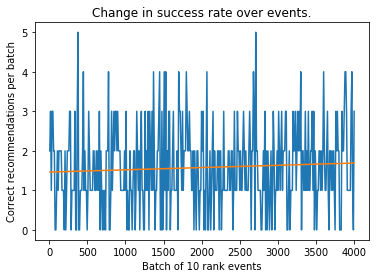

In [22]:

plt.plot(count, rewards)
plt.plot(count, y, '-')
plt.xlabel("Batch of 10 rank events")
plt.ylabel("Correct recommendations per batch")
plt.title("Change in success rate over events.")
plt.show()

From the above plot, you can observe that the ranking gets better after ~2000 events and performs well over ~80% of the time. Since, the exploration is set to 20%, 20% of the time the system still tries to explore the other options. See https://docs.microsoft.com/en-us/azure/cognitive-services/personalizer/ for more documentation.